In [22]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_selection, ensemble, model_selection
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('./data/digit recognizor.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data.shape

(42000, 785)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [5]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

In [6]:
y.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [ ]:
# 我们有四种方法进行特征的选择：过滤法，嵌入法，包装法，降维算法
# 过滤法：VarianceThreshold

In [7]:
# 通过VarianceThreshold 剔除方差为0的特征 由下面数据可知 明显减少了很多特征
selector = feature_selection.VarianceThreshold()
x_var0 = selector.fit_transform(X)
x_var0.shape

(42000, 708)

In [8]:
# 如果我们想要留下一半的特征，我们可以把参数threshold设置特征方差的中位数
x_fsvar = feature_selection.VarianceThreshold(threshold=np.median(X.var().values)).fit_transform(X)
x_fsvar.shape

(42000, 392)

In [13]:
# 如果特征是二分类，特征的取值就是伯努利随机变量，这些变量的方差可以计算为 Var = p(1 - p) 
# p为其中某一个分类特征的概率
# 过滤
x_bvar = feature_selection.VarianceThreshold(0.8 * (1 - 0.8)).fit_transform(X)
x_bvar.shape

(42000, 685)

In [14]:
# Line magic 
%%timeit
feature_selection.VarianceThreshold(0.8 * (1 - 0.8)).fit_transform(X)

UsageError: Line magic function `%%timeit` not found.


In [15]:
# 方差过滤后，到底过滤掉的是噪音还是有效特征，是变好还是变坏呢？我们可以画学习曲线，寻找模型效果最好的点
# 但现实中，我们不会这样做，因为这样太耗费时间。我们只会使用阈值为0或者阈值很小的方差进行过滤，
# 来消除一些我们明显用不到的特征，然后我们使用更优的特征进选择方法继续消减特征数量
# 1）卡方过滤
# 2）F检验
# 3）互信息

In [19]:
# 1) 卡方过滤 是专门针对离散型标签的相对性过滤  卡方过滤是计算每个非负特征和标签之间的卡方统计量，并依照卡方统计量从高到低为特征排名，
# 在结合feature_selection.SelectKBest 这个输入评分标准选出前K个分数最高的特征类
feature_selection.SelectKBest
x_fschi = feature_selection.SelectKBest(score_func=feature_selection.chi2, k=300).fit_transform(x_fsvar, y)
x_fschi.shape

(42000, 300)

In [21]:
%%timeit
model_selection.cross_val_score(ensemble.RandomForestClassifier(n_estimators=10), 
                                x_fschi, 
                                y, 
                                cv=5).mean()

9.85 s ± 82.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


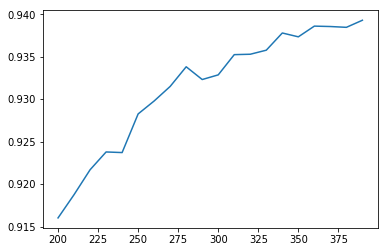

In [24]:
# 接下来我们看看k的学习曲线
scores = []
for i in range(200, 400, 10):
    x_fschi = feature_selection.SelectKBest(feature_selection.chi2, k=i).fit_transform(x_fsvar, y)
    clf = ensemble.RandomForestClassifier(n_estimators=10, n_jobs=-1)
    score_mean = model_selection.cross_val_score(clf, x_fschi, y, cv=5).mean()
    scores.append(score_mean)
plt.plot(range(200, 400, 10), scores)
plt.show()
    

In [25]:
chivalue, pvalues_chi = feature_selection.chi2(x_fsvar, y)
print(chivalue)
print('********' * 15)
print(pvalues_chi)

[ 945664.84392643 1244766.05139164 1554872.30384525 1834161.78305343
 1903618.94085294 1845226.62427198 1602117.23307537  708535.17489837
  974050.20513718 1188092.19961931 1319151.43467036 1397847.8836796
 1433554.26798015 1429043.15373433 1332663.17213405 1101423.25372261
  809989.56940485  519266.71772284  285681.88297156  191589.23696468
  902883.1255264  1237265.16042373 1503477.73699155 1625807.41495542
 1630206.90922916 1630597.02883804 1633456.72909664 1610816.75571229
 1483382.49543886 1256290.1574794   951236.1617682   693192.66191748
  532386.96220361  504617.38933715  575090.36046243  501025.03733245
  802341.10683194 1078344.8724406  1226540.98318702 1269945.07968831
 1221758.57688808 1146535.17810241 1080657.20185303 1079065.30979135
 1092222.70610032 1064908.45385716 1023327.00231067  974163.15420165
  918857.12860617  861439.52030749  828439.23565047  916454.89464771
  989713.58229958  543695.5016699   674691.76755044  708113.57226969
  657819.3908855   599159.21961671 

In [26]:
chivalue.shape

(392,)

In [27]:
# k取多少？我们想要消除所有的p值大于设定值，比如0.05或0.01的特征
k = chivalue.shape[0] - (pvalues_chi > 0.05).sum()
k

392

In [30]:
# 2) F检验 又称方差齐性检验，是用来捕捉每个特征与标签之间的线性关系的过滤方法。
# feature_selection.f_classif  用于分类
# feature_selection.f_regression 用于回归
F, pvalues_f = feature_selection.f_classif(x_fsvar, y)
print(F)
print('*********' * 15)
print(pvalues_f)

[ 618.65383492  846.18897012 1115.40617051 1362.3677305  1452.03355369
 1381.09095571 1138.26505266  464.29616121  660.00977785  849.66393412
 1004.7450309  1124.76177588 1200.99190762 1209.29489877 1110.4944286
  854.66183292  577.52063451  342.09729054  178.67397866  118.01145533
  612.12261014  899.40904291 1196.17528948 1424.49864852 1569.26556677
 1742.49910702 1910.98023795 1969.20520223 1731.37475948 1295.09668012
  839.15325001  531.97951763  371.82392681  336.00820537  378.93378743
  317.47025479  528.94881012  766.40792176  947.63168717 1086.0472161
 1177.72017709 1253.79641973 1344.06961068 1507.33781169 1616.50454434
 1512.25864876 1289.65180587 1051.26276412  839.48869386  680.07426932
  600.85538567  633.55772663  683.96908509  347.65867784  452.76238211
  509.16387684  515.7498157   532.86107778  594.62512658  664.18740444
  709.37133696  798.11767931  876.69849088  852.76926441  785.70173347
  802.88980095  813.2041131   760.85552527  687.94148028  642.84071735
  698.11

In [31]:
k = F.shape[0] - (pvalues_f > 0.05).sum()
k

392

In [33]:
# 3) 互信息法是用来捕捉每个特征与标签特征之间的任意关系的过滤方法 与F检验相似 
# 返回一个估计量在[0, 1]之间取值，为0表示两个变量独立，为1表示两个变量完全相关
result = feature_selection.mutual_info_classif(x_fsvar, y)
k = result.shape[0] - sum(result <= 0)
k

392